# Naive Neural Network Implementation: Binary Classification
Uses transcript to predict presence of depression. Recall that a PHQ_Score of 10 and above is considered as depression.

# Load and Clean Data

In [1]:
import pandas as pd
import string
import re as re

df = pd.read_csv("../data/raw_compiled_transcripts.csv")
df.Transcript = df.Transcript.apply(lambda x: re.sub('<[^<]+?>', '', x))
df.Transcript = df.Transcript.apply(lambda x: x.translate(str.maketrans("","",string.punctuation)))

df.head()

,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,330,yes im okay with this very good la its sunny ...,12,1
1,352,yes im doing pretty good im from oklahoma ...,10,1
2,334,okay yes pretty good a little tired seattle wa...,5,0
3,443,sure good indiana um the weather i like the w...,1,0
4,421,yes thats fine im okay how are you originall...,10,1


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.Transcript, df.PHQ_Binary, test_size=0.2, random_state=42)

# Tokenization and Padding

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

vocab_size = 5000 # only the top 5000 words are indexed when tokenized
maxlen = 80 # cut texts after this number of words

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index

Using TensorFlow backend.


{'i': 1,
 'and': 2,
 'to': 3,
 'um': 4,
 'a': 5,
 'the': 6,
 'uh': 7,
 'that': 8,
 'you': 9,
 'my': 10,
 'it': 11,
 'of': 12,
 'know': 13,
 'like': 14,
 'was': 15,
 'just': 16,
 'im': 17,
 'in': 18,
 'so': 19,
 'but': 20,
 'its': 21,
 'dont': 22,
 'have': 23,
 'me': 24,
 'not': 25,
 'with': 26,
 'really': 27,
 'for': 28,
 'be': 29,
 'do': 30,
 'think': 31,
 'or': 32,
 'yeah': 33,
 'about': 34,
 'on': 35,
 'is': 36,
 'people': 37,
 'well': 38,
 'things': 39,
 'good': 40,
 'when': 41,
 'very': 42,
 'as': 43,
 'get': 44,
 'at': 45,
 'what': 46,
 'out': 47,
 'no': 48,
 'been': 49,
 'thats': 50,
 'had': 51,
 'ive': 52,
 'lot': 53,
 'time': 54,
 'more': 55,
 'we': 56,
 'go': 57,
 'if': 58,
 'would': 59,
 'they': 60,
 'up': 61,
 'pretty': 62,
 'probably': 63,
 'from': 64,
 'one': 65,
 'can': 66,
 'all': 67,
 'because': 68,
 'there': 69,
 'then': 70,
 'life': 71,
 'some': 72,
 'now': 73,
 'something': 74,
 'little': 75,
 'years': 76,
 'much': 77,
 'feel': 78,
 'say': 79,
 'guess': 80,
 'she': 

# Transform original data

In [4]:
def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X) # convert text to sequence
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen) # word embedding matrix expects fixed size sentences
    
    return X_mat

In [5]:
X_train_mat = prepare(X_train)
X_test_mat = prepare(X_test)

# Build the Model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 128)           640000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1310848   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,950,977
Trainable params: 1,950,977
Non-trainable params: 0
_________________________________________________________________
None


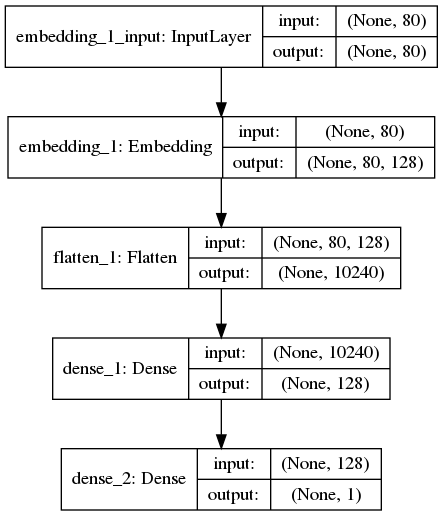

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='naiveNN_binary.png', show_shapes=True)

# Train the Model

In [8]:
from keras.callbacks import EarlyStopping

batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mae', 'accuracy'])

model.fit(X_train_mat, y_train, batch_size=batch_size, epochs=30, validation_split=0.2, callbacks=[es])
loss, mae, acc = model.evaluate(X_test_mat, y_test, batch_size=batch_size)

print('Test loss:', loss)
print('Test mean absolute error', mae)
print('Test accuracy:', acc)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 115 samples, validate on 29 samples
Epoch 1/30
115/115 [==============================] - 1s 5ms/step - loss: 0.6695 - mae: 0.4834 - accuracy: 0.6522 - val_loss: 0.5909 - val_mae: 0.4275 - val_accuracy: 0.7586
Epoch 2/30
115/115 [==============================] - 0s 128us/step - loss: 0.3089 - mae: 0.2509 - accuracy: 0.9217 - val_loss: 0.5642 - val_mae: 0.3850 - val_accuracy: 0.7586
Epoch 3/30
115/115 [==============================] - 0s 126us/step - loss: 0.1272 - mae: 0.1145 - accuracy: 1.0000 - val_loss: 0.5572 - val_mae: 0.3653 - val_accuracy: 0.7586
Epoch 4/30
115/115 [==============================] - 0s 117us/step - loss: 0.0418 - mae: 0.0405 - accuracy: 1.0000 - val_loss: 0.5570 - val_mae: 0.3531 - val_accuracy: 0.7586
Epoch 5/30
115/115 [==============================] - 0s 117us/step - loss: 0.0143 - mae: 0.0142 - accuracy: 1.0000 - val_loss: 0.5619 - val_mae: 0.3429 - val_accuracy: 0.7586
Epoch 6/30
115/115 [==============================] - 0s 117us/step - loss: 0

# Make predictions

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specificity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

AUC is:  0.5
              precision    recall  f1-score   support

           0       0.57      1.00      0.72        21
           1       0.00      0.00      0.00        16

    accuracy                           0.57        37
   macro avg       0.28      0.50      0.36        37
weighted avg       0.32      0.57      0.41        37

Confusion Matrix: 
 [[21  0]
 [16  0]]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


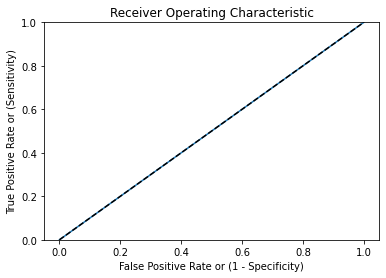

In [10]:
import numpy as np

predictions = model.predict(X_test_mat)
y_pred = np.where(predictions > 0.5, 1, 0).flatten()

evaluate_on_training_set(y_test, y_pred)

The model is not performing any better, if not worse, than random predictions. All of the depressed participants are incorrectly predicted as normal.